In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import copy
import pickle
import io
from itertools import permutations
from simulators.turin import turin

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

        
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load(f"{root_name}/sum_net.pkl", map_location=device)

    density_estimator = torch.load(f"{root_name}/density_estimator.pkl", map_location=device)

    with open(f"{root_name}/posterior.pkl", "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior


def read_rnpe(model="turin", misspecified=0, seed=1, theta=[4,10]):
    file = f"seed={seed}_var={misspecified}_theta={theta}_{model}"

    results_dir = f"objects/rnpe/{model}/"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])


def sample_posteriors(posterior, obs, num):
    return posterior.sample((num,), x=obs.reshape(1, 1, 100, 801), show_progress_bars=True)

In [72]:
def temporalMomentsGeneral(Y, K=4, B=4e9):
    N, Ns = Y.shape
    delta_f = B / (Ns-1)
    t_max = 1 / delta_f
    tau = np.linspace(0, t_max, Ns)
    m = np.zeros((N, K))
    for k in range(K):
        for i in range(N):
            y = np.fft.ifft(Y[i, :])
            m[i, k] = np.trapz(tau**(k) * (np.abs(y)**2), tau)
    return np.log(m)

In [73]:
temporalMomentsGeneral(obs_real)

array([[-13.20415638, -33.78182564, -49.33960452, -64.8375634 ],
       [-13.21085215, -33.77175976, -49.33781998, -64.84094682],
       [-13.21583414, -33.851506  , -49.42956753, -64.94021746],
       [-13.21196734, -33.80559702, -49.37317791, -64.87724012],
       [-13.21761048, -33.85404098, -49.40387147, -64.8969703 ],
       [-13.20475877, -33.83632208, -49.41005396, -64.91798611],
       [-13.22864906, -33.89018981, -49.47019834, -64.98209382],
       [-13.20571764, -33.85182838, -49.42348488, -64.9300978 ],
       [-13.21715822, -33.90540808, -49.48893625, -65.00308511],
       [-13.2100876 , -33.79063362, -49.35833566, -64.86245505],
       [-13.21533211, -33.87217548, -49.45497242, -64.96866234],
       [-13.21632493, -33.81787423, -49.38046392, -64.88141966],
       [-13.20639284, -33.75981962, -49.34728687, -64.86400253],
       [-13.2155827 , -33.88698813, -49.46960738, -64.98317315],
       [-13.20539142, -33.81898239, -49.39173703, -64.89907805],
       [-13.21910039, -33

In [76]:
prior = [[1e-9, 1e-8], [1e-9, 1e-8], [1e7, 5e9], [1e-10, 1e-9]]

theta = torch.tensor(np.load("data/turin_theta_2000_tau6.npy"))
x = torch.tensor(np.load("data/turin_x_2000_tau6.npy")).reshape(2000, 100, 801)

simulator = turin(B=4e9, Ns=801, N=100, tau0=6e-9)
theta_gt = torch.tensor([10**(-8.4), 7.8e-9, 1e9, 2.8e-10])
obs_sim = simulator(theta_gt).to(device)

obs_real = torch.tensor(np.load("data/turin_obs.npy")).float()

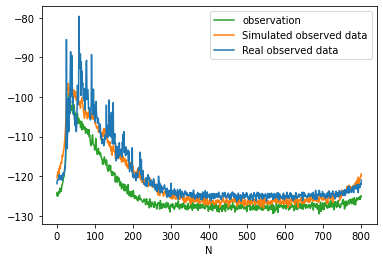

In [4]:
plt.plot(np.arange(801), torch.mean(x[10], axis=0), color="tab:green", label="observation")
plt.plot(np.arange(801), torch.mean(obs_sim, axis=0), color="tab:orange", label="Simulated observed data")
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="tab:blue", label="Real observed data")

plt.legend()
plt.xlabel("N")
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

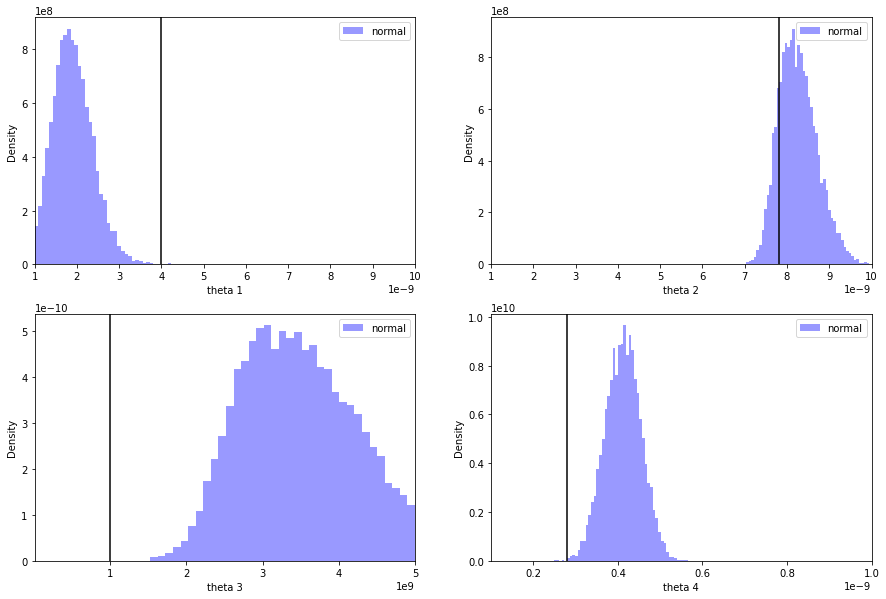

In [77]:
root_name = "objects/turin/none_num=2000_N=100_tau6/16"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_cont = posterior_normal.sample((10000,), x=obs_real.reshape(1, 1, 100, 801))
post_samples_normal = posterior_normal.sample((10000,), x=obs_sim.reshape(1, 1, 100, 801))

plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.axvline(x=theta_gt[i],ls="-",c="black")
    sns.distplot(post_samples_cont[:, i].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
    plt.legend()
    plt.xlim(prior[i][0], prior[i][1])
#     plt.title(f"Corrupted data - theta {i+1}")
    plt.xlabel(f"theta {i+1}")
    plt.ylabel("Density")
#     plt.xscale("log")
plt.show()


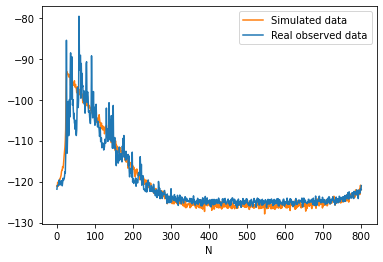

In [62]:
theta_gt = torch.tensor([2e-9, 8e-9, 1e10, 3.5e-10])
obs_sim = simulator(theta_gt).to(device)

plt.plot(np.arange(801), torch.mean(obs_sim, axis=0), color="tab:orange", label="Simulated data")
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="tab:blue", label="Real observed data")

plt.legend()
plt.xlabel("N")
plt.show()

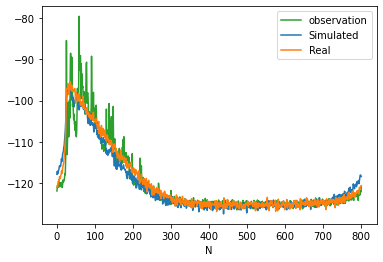

In [45]:
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="tab:green", label="observation")
# plt.plot(np.arange(801), torch.mean(obs_sim, axis=0), color="tab:blue", label="Simulated observed data")

predictive_samples_normal = simulator(torch.mean(post_samples_normal, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_normal, axis=0), color="tab:blue", label="Simulated")

predictive_samples_cont = simulator(torch.mean(post_samples_cont, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_cont, axis=0), color="tab:orange", label="Real")

# predictive_samples_robust = simulator(torch.mean(post_samples_robust_cont, axis=0))
# plt.plot(np.arange(801), torch.mean(predictive_samples_robust, axis=0), color="tab:blue", label="NPE-RS")

plt.legend()
plt.xlabel("N")
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9972 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


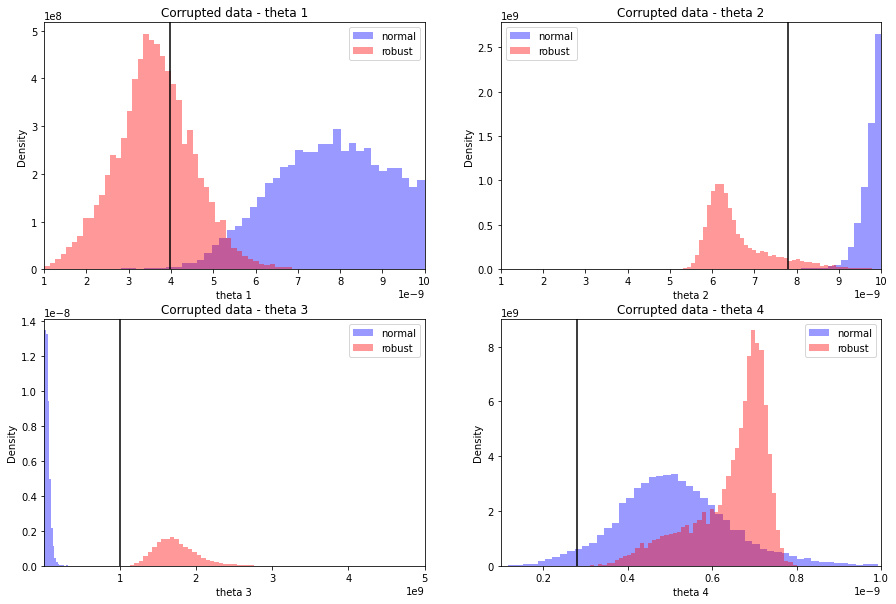

In [59]:
root_name = "objects/turin/none_num=2000_N=100_tau0/1"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)
root_name = "objects/turin/mmd_beta=2.0_num=2000_N=100_tau6/3"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_real.reshape(1, 1, 100, 801))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_real.reshape(1, 1, 100, 801))

plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.axvline(x=theta_gt[i],ls="-",c="black")
    sns.distplot(post_samples_normal_cont[:, i].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
    sns.distplot(post_samples_robust_cont[:, i].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
    plt.legend()
    plt.xlim(prior[i][0], prior[i][1])
    plt.title(f"Corrupted data - theta {i+1}")
    plt.xlabel(f"theta {i+1}")
    plt.ylabel("Density")
    
plt.show()


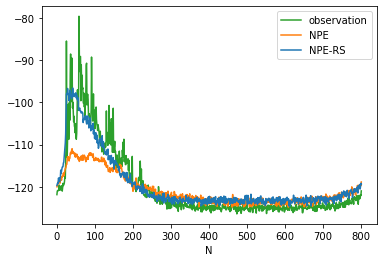

In [60]:
plt.plot(np.arange(801), torch.mean(obs_real, axis=0), color="tab:green", label="observation")

predictive_samples_normal = simulator(torch.mean(post_samples_normal_cont, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_normal, axis=0), color="tab:orange", label="NPE")

predictive_samples_robust = simulator(torch.mean(post_samples_robust_cont, axis=0))
plt.plot(np.arange(801), torch.mean(predictive_samples_robust, axis=0), color="tab:blue", label="NPE-RS")

plt.legend()
plt.xlabel("N")
plt.show()

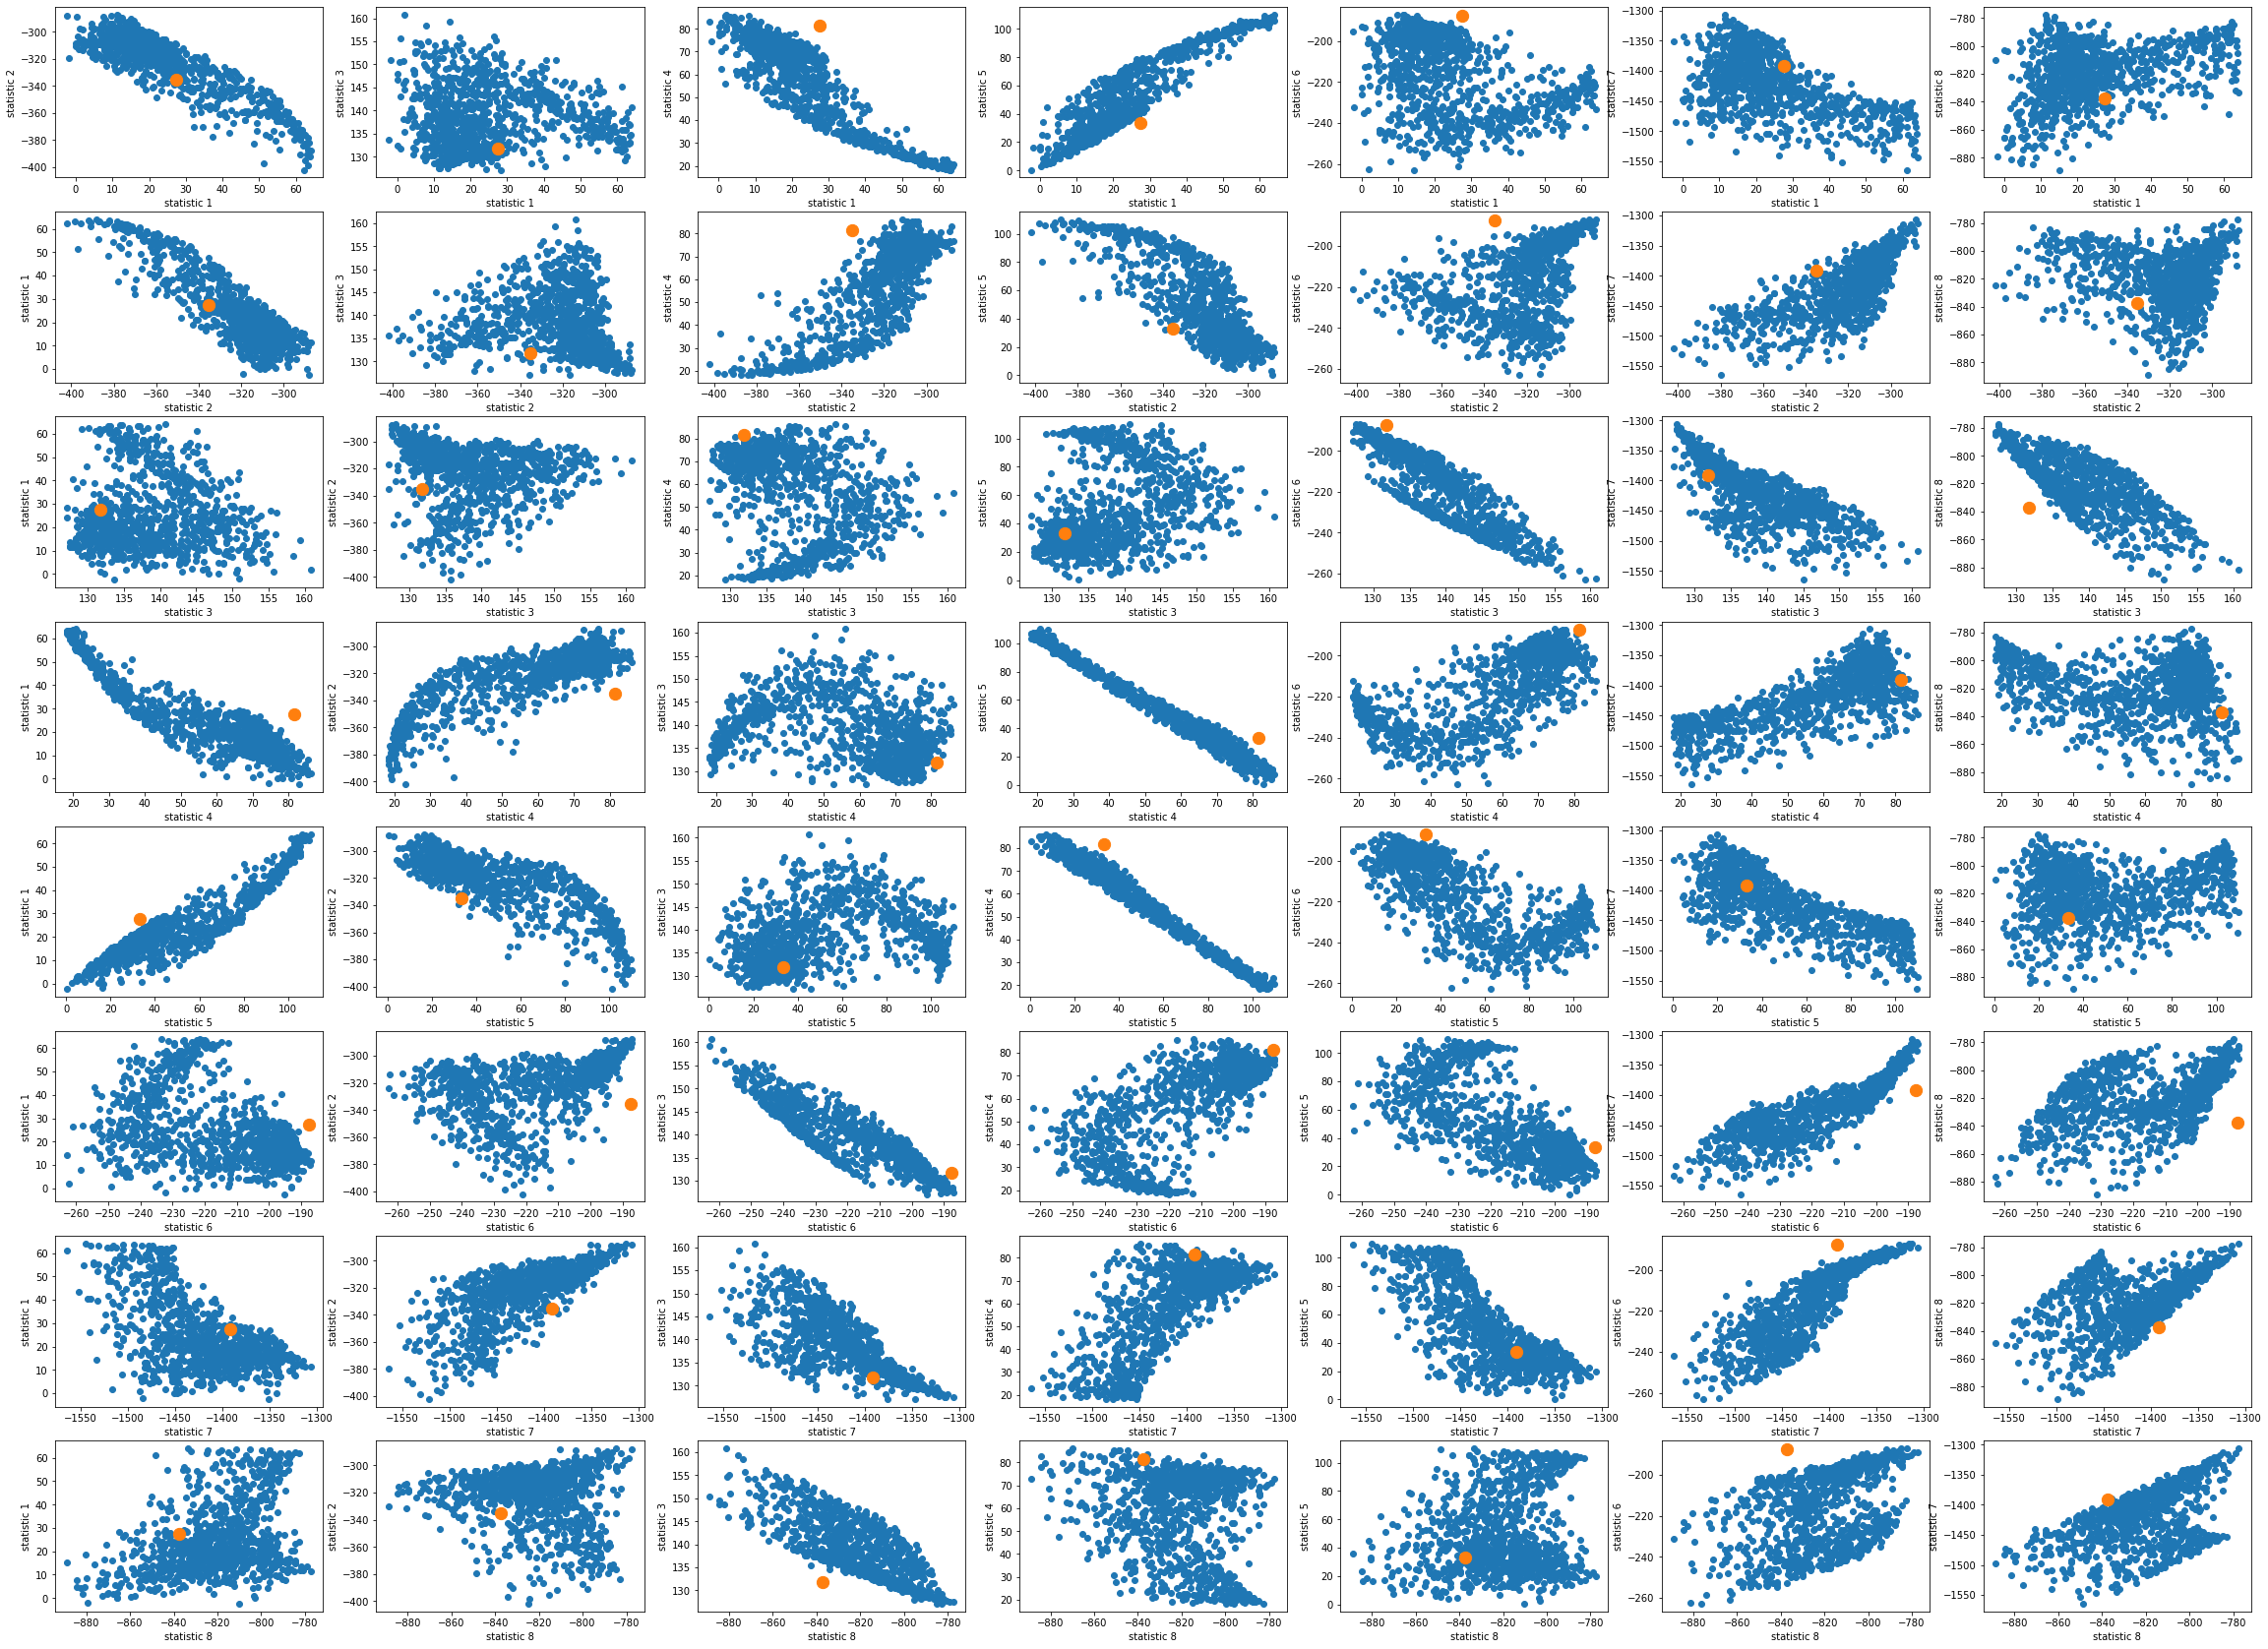

In [49]:
obs_summary = sum_net_normal(obs_real.unsqueeze(0))[1].detach().numpy()
x_summary = sum_net_normal(x[:1000])[1].detach().numpy()

stat = list(permutations(range(8), 2))

plt.figure(figsize=(40, 30))
for i in range(len(stat)):
    plt.subplot(8, 7, i+1)
    plt.scatter(x_summary[:, stat[i][0]], x_summary[:, stat[i][1]])
    plt.scatter(obs_summary[0, stat[i][0]], obs_summary[0, stat[i][1]], s=150)
    plt.xlabel(f"statistic {stat[i][0]+1}")
    plt.ylabel(f"statistic {stat[i][1]+1}")
plt.show()

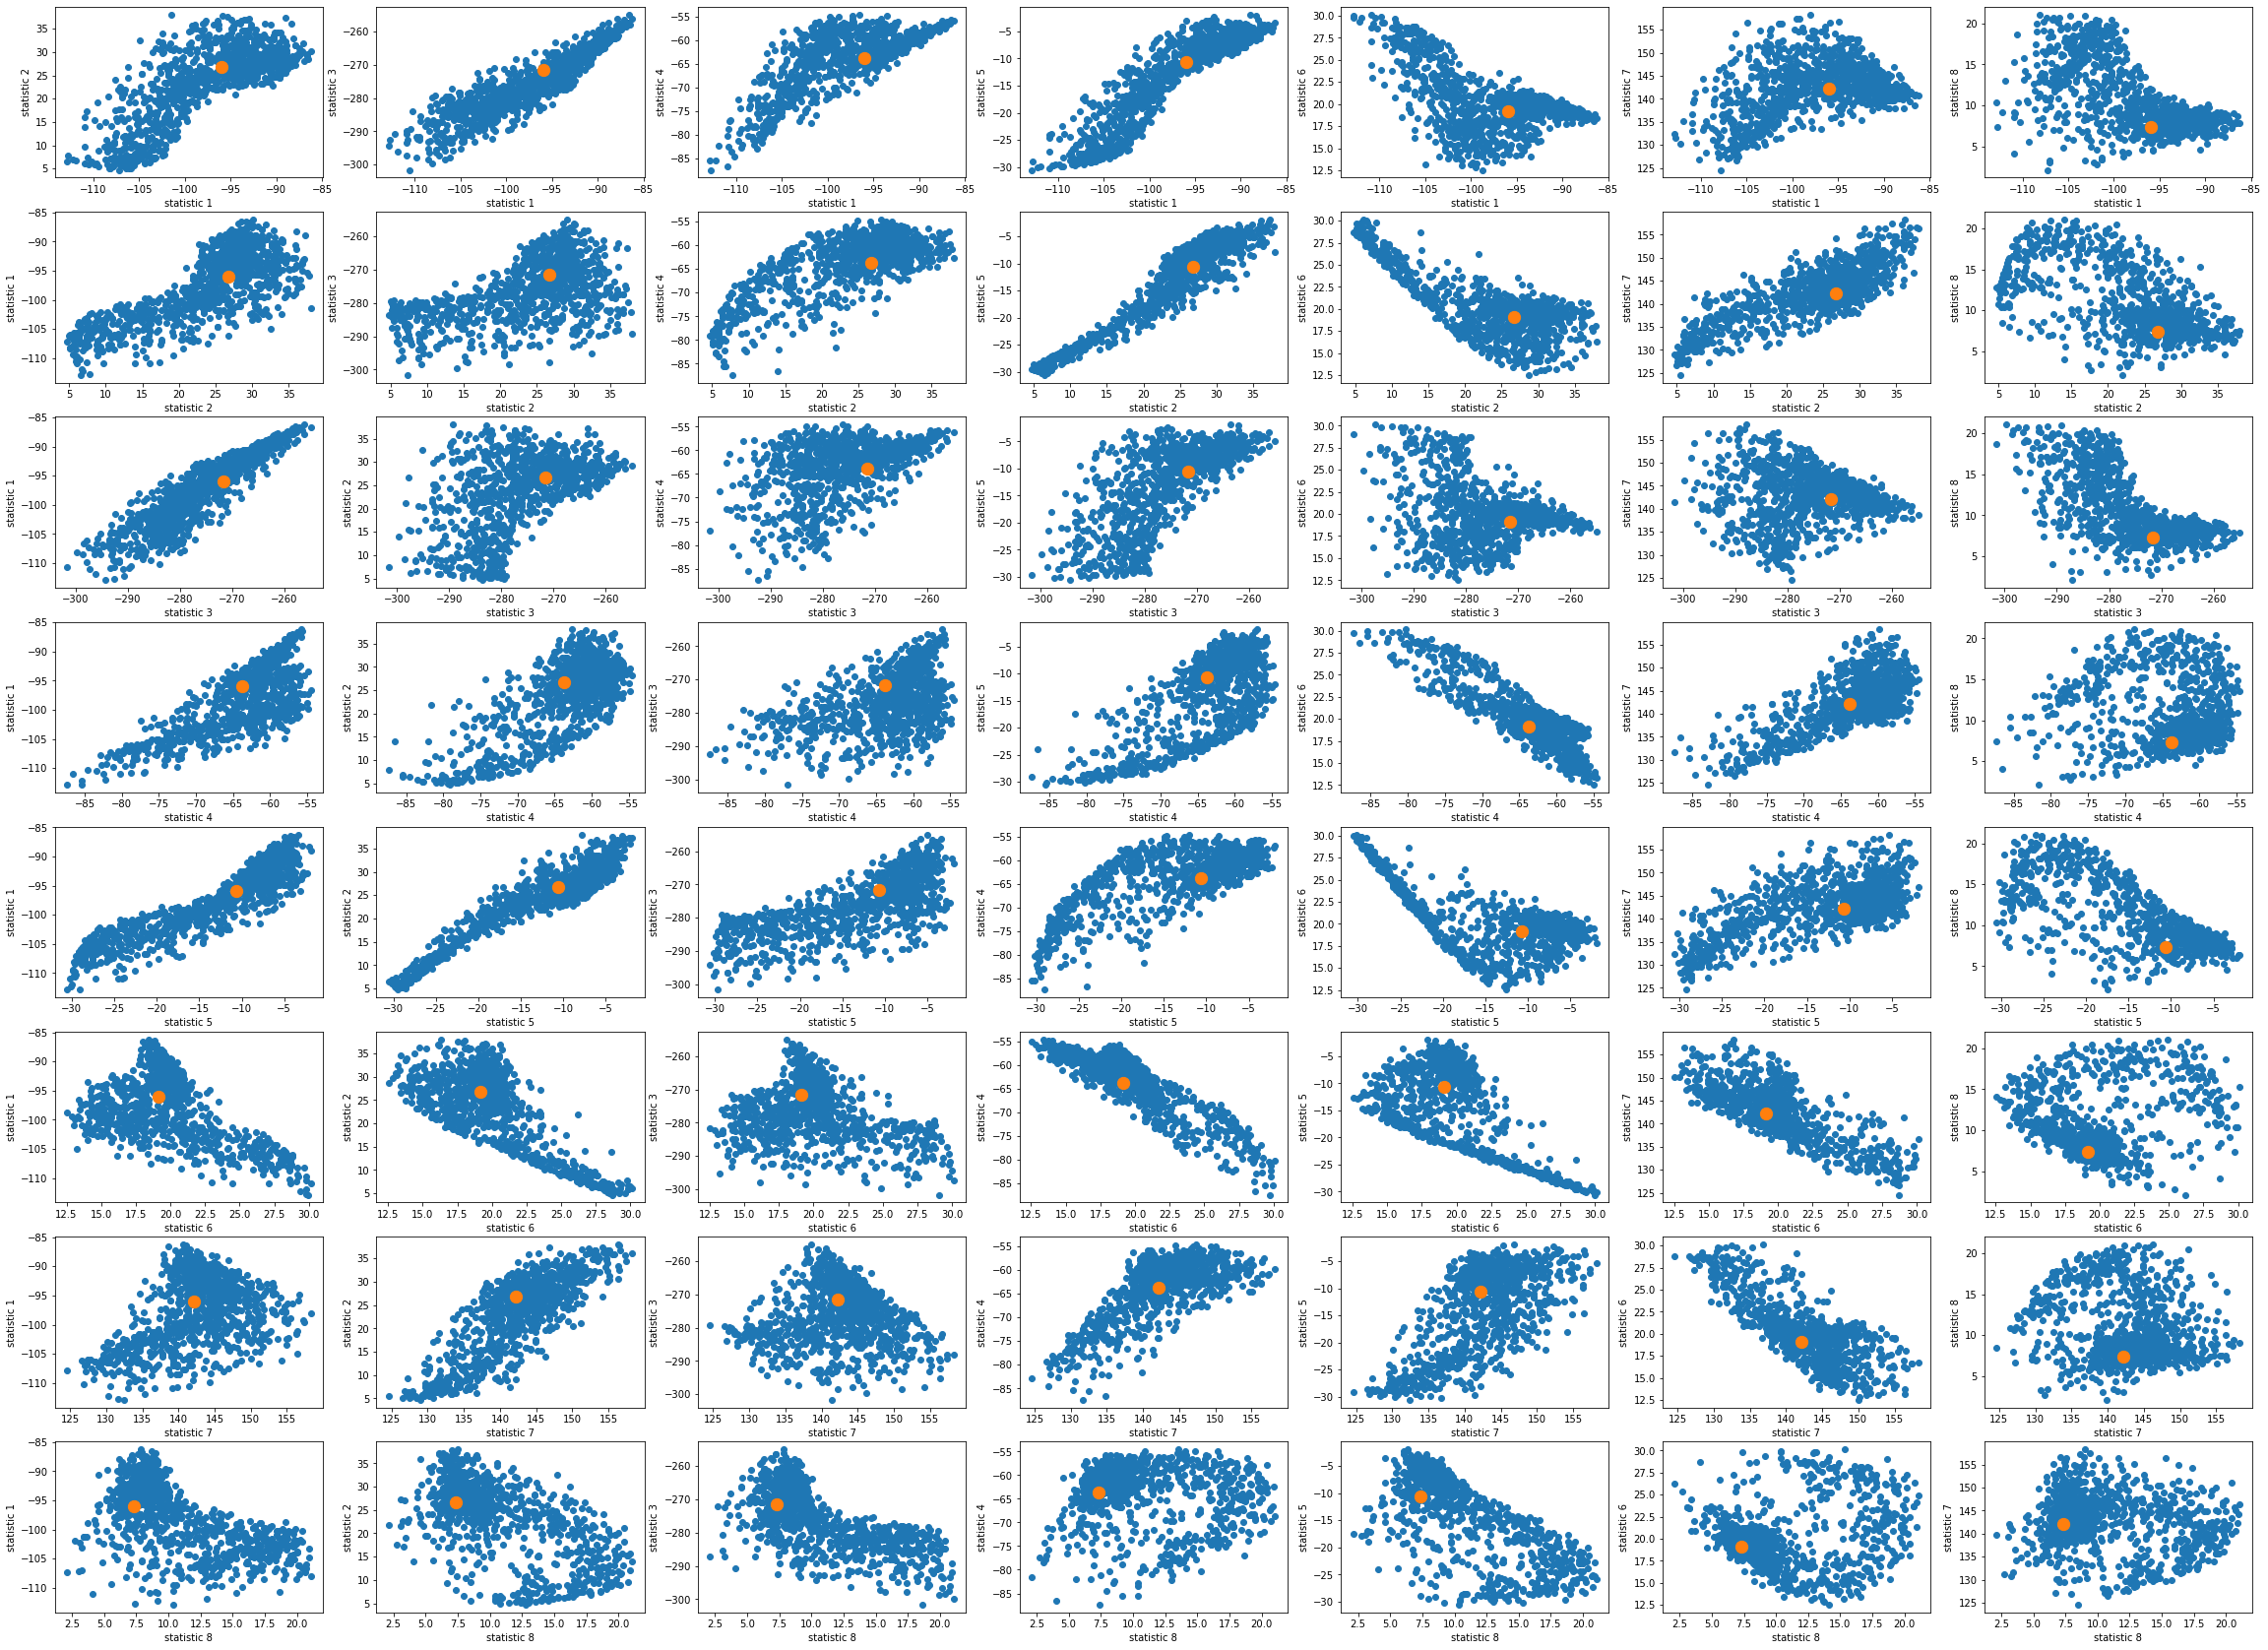

In [61]:
obs_summary = sum_net_robust(obs_real.unsqueeze(0))[1].detach().numpy()
x_summary = sum_net_robust(x[:1000])[1].detach().numpy()

stat = list(permutations(range(8), 2))

plt.figure(figsize=(40, 30))
for i in range(len(stat)):
    plt.subplot(8, 7, i+1)
    plt.scatter(x_summary[:, stat[i][0]], x_summary[:, stat[i][1]])
    plt.scatter(obs_summary[0, stat[i][0]], obs_summary[0, stat[i][1]], s=150)
    plt.xlabel(f"statistic {stat[i][0]+1}")
    plt.ylabel(f"statistic {stat[i][1]+1}")
plt.show()

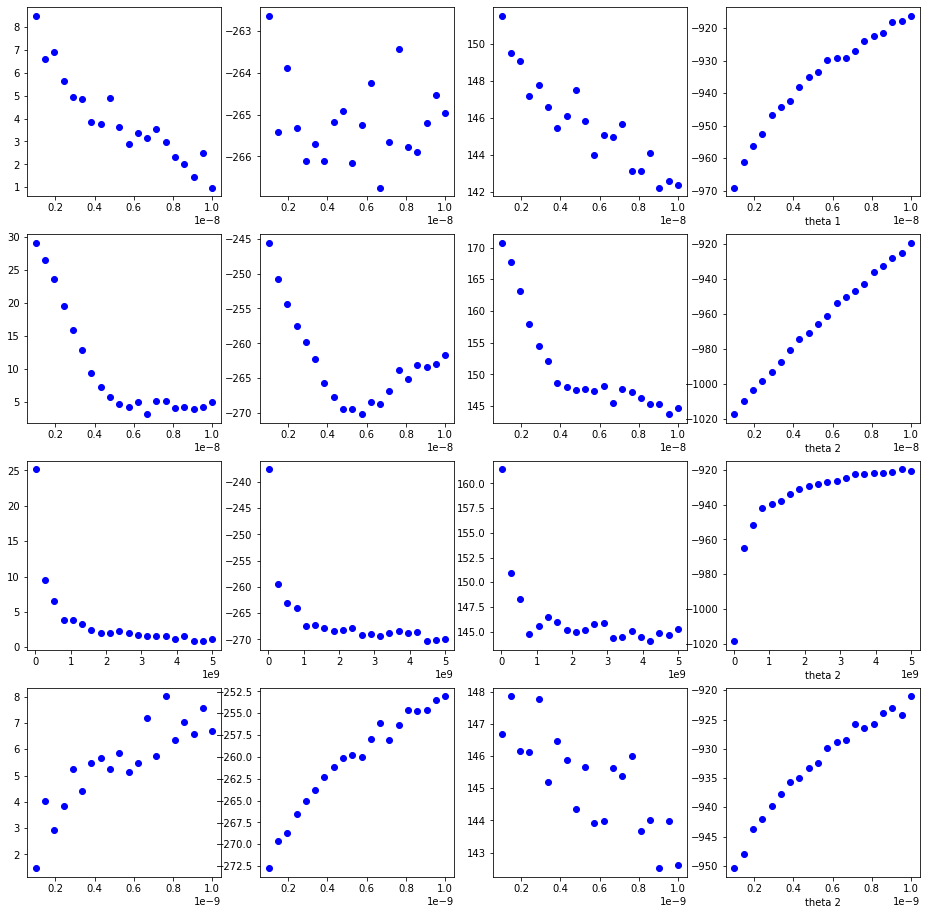

In [31]:
n_samples = 100

theta_1 = np.linspace(1e-9, 1e-8, 20)
theta_2= np.linspace(1e-9, 1e-8, 20)
theta_3 = np.linspace(1e7, 5e9, 20)
theta_4= np.linspace(1e-10, 1e-9, 20)
theta_1_unchange = np.repeat(10**(-8.4), 20)
theta_2_unchange = np.repeat(7.8e-9, 20)
theta_3_unchange = np.repeat(1e9, 20)
theta_4_unchange = np.repeat(2.8e-10, 20)

thetas_1 = torch.tensor(np.stack((theta_1, theta_2_unchange, theta_3_unchange, theta_4_unchange), axis=-1))
thetas_2 = torch.tensor(np.stack((theta_1_unchange, theta_2, theta_3_unchange, theta_4_unchange), axis=-1))
thetas_3 = torch.tensor(np.stack((theta_1_unchange, theta_2_unchange, theta_3, theta_4_unchange), axis=-1))
thetas_4 = torch.tensor(np.stack((theta_1_unchange, theta_2_unchange, theta_3_unchange, theta_4), axis=-1))

hidden_1_normal = np.zeros((len(thetas_1), 8))
hidden_2_normal = np.zeros((len(thetas_2), 8))
hidden_3_normal = np.zeros((len(thetas_3), 8))
hidden_4_normal = np.zeros((len(thetas_4), 8))

for i in range(len(thetas_1)):
    obs_1 = simulator(thetas_1[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)
    obs_2 = simulator(thetas_2[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)
    obs_3 = simulator(thetas_3[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)
    obs_4 = simulator(thetas_4[i].reshape(-1, 4)).reshape(1, n_samples, 801).to(device)

    hidden_1_normal[i] = sum_net_normal(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2_normal[i] = sum_net_normal(obs_2)[1].reshape(-1).cpu().detach().numpy()
    hidden_3_normal[i] = sum_net_normal(obs_3)[1].reshape(-1).cpu().detach().numpy()
    hidden_4_normal[i] = sum_net_normal(obs_4)[1].reshape(-1).cpu().detach().numpy()


plt.figure(figsize=(16,16))
plt.subplot(4, 4, 1)
plt.scatter(theta_1, hidden_1_normal[:, 0], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 0], color="red")
plt.subplot(4, 4, 2)
plt.scatter(theta_1, hidden_1_normal[:, 1], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 1], color="red")
plt.subplot(4, 4, 3)
plt.scatter(theta_1, hidden_1_normal[:, 2], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 2], color="red")
plt.subplot(4, 4, 4)
plt.scatter(theta_1, hidden_1_normal[:, 3], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 3], color="red")
plt.xlabel("theta 1")

plt.subplot(4, 4, 5)
plt.scatter(theta_2, hidden_2_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 6)
plt.scatter(theta_2, hidden_2_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 7)
plt.scatter(theta_2, hidden_2_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 8)
plt.scatter(theta_2, hidden_2_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")

plt.subplot(4, 4, 9)
plt.scatter(theta_3, hidden_3_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 10)
plt.scatter(theta_3, hidden_3_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 11)
plt.scatter(theta_3, hidden_3_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 12)
plt.scatter(theta_3, hidden_3_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")

plt.subplot(4, 4, 13)
plt.scatter(theta_4, hidden_4_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 14)
plt.scatter(theta_4, hidden_4_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 15)
plt.scatter(theta_4, hidden_4_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 16)
plt.scatter(theta_4, hidden_4_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")
plt.show()